# School analysis
Testing out functions in schools.py, and looking at centrality over time

## Libaries

In [1]:
import schools as s
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import seaborn as sns

In [2]:
%matplotlib inline

## Import data

In [3]:
students = s.get_all_students()

In [4]:
students.head()

,Unnamed: 0,id,student_id,student_name,student_school,student_year,student_descendants,advisor_name,advisor_school,advisor_year,advisor_year_dec,student_year_dec
0,0,233136,233138,"Mogstad, Magne",Universitetet i Oslo,2008,1,"Aaberge, Rolf",Universitetet i Oslo,1976,1970s,2000s
1,1,13670,106100,"Anagnostakis, Christopher",Yale University,1984,,"Aaboe, Asger",Brown University,1957,1950s,1980s
2,2,13670,122878,"Britton, John",Yale University,1966,,"Aaboe, Asger",Brown University,1957,1950s,1960s
3,3,13670,122880,"Slotsky, Alice",Yale University,1992,1,"Aaboe, Asger",Brown University,1957,1950s,1990s
4,4,13670,122881,"Swerdlow, Noel",Yale University,1968,,"Aaboe, Asger",Brown University,1957,1950s,1960s


## Analysis

### Eigenvector centrality by decade

In [5]:
def top_degree_subgraph(dg, weight_col_name, n):
    degrees =  pd.DataFrame(list(nx.degree(dg, weight = weight_col_name)), columns = ["node", "degree"])
    top_n_nodes = degrees.sort_values("degree", ascending = False).iloc[:n]["node"].values
    return dg.subgraph(top_n_nodes)

In [6]:
decades = [str(1950 + 10 * i) + "s" for i in range(7)]

In [7]:
decade_school_digraphs = [{
    "decade": dec,
    "school_dg": s.make_school_digraph(students.query("student_year_dec == '{}'".format(dec)))} for dec in decades]

In [8]:
for dec_s_dg in decade_school_digraphs:
    dec_s_dg["school_sg"] = top_degree_subgraph(dec_s_dg["school_dg"], "weight", 15)
    dec_s_dg["deg"] = dict(dec_s_dg["school_sg"].out_degree(weight = "weight"))
    dec_s_dg["cent"] = nx.eigenvector_centrality(dec_s_dg["school_sg"].reverse(), weight='weight', max_iter = 1000)

In [9]:
def draw_graph_layout_cent(graph, layout, ax, cent = None):
    """
    draw the graph with the given layout on the given axis
    """
    cent_list = [200 * cent[k] if cent else 10 for k, v in layout.items()]
    ax.scatter([v[0] for k, v in layout.items()], [v[1] for k, v in layout.items()], s = cent_list)
    for k, v in layout.items():
        ax.annotate(k, v, xytext = (5, 5), textcoords = "offset points", fontsize = 10 + 5 * cent[k] if cent else 12)
    for e in [e for e in graph.edges]:
        ax.plot([layout[i][0] for i in e], [layout[i][1] for i in e], c = "steelblue", lw = 0.1)

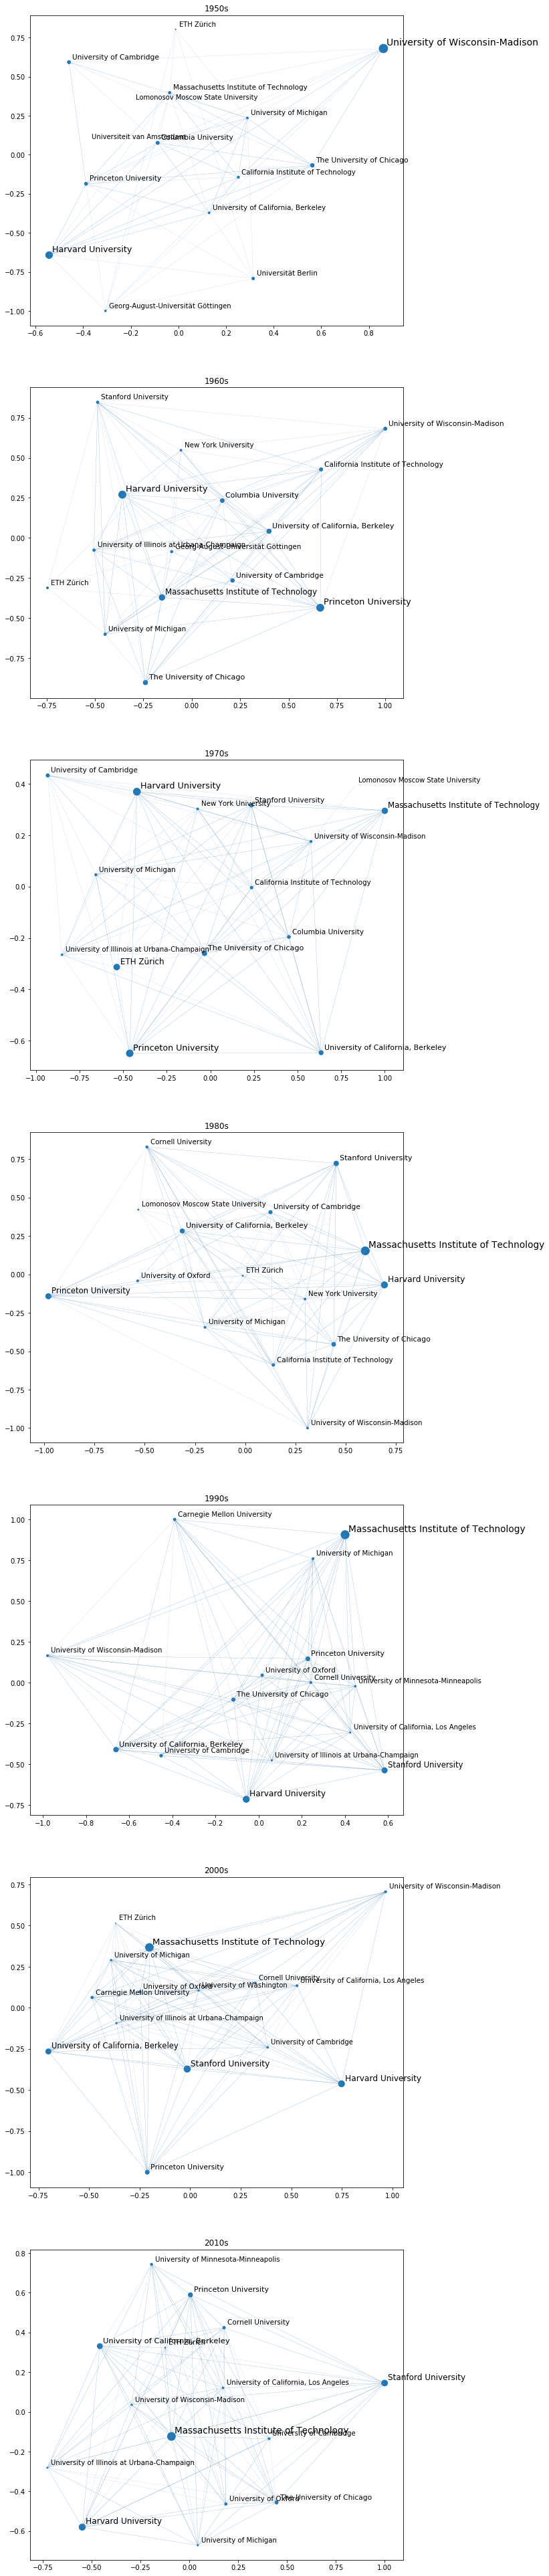

In [10]:
fig, ax = plt.subplots(figsize = (10, 10 * len(decades)), nrows = len(decades))
for i, d in enumerate(decade_school_digraphs):
    layout = nx.kamada_kawai_layout(d["school_sg"])
    draw_graph_layout_cent(d["school_sg"], layout, ax[i], cent = d["cent"])
    ax[i].set_title(d["decade"])

### Eigenvector centrality over time

In [11]:
all_cent = pd.concat(
    [pd.DataFrame([{"school": k, "cent": v, "decade": d["decade"]} for k, v in d["cent"].items()]) for d in decade_school_digraphs])

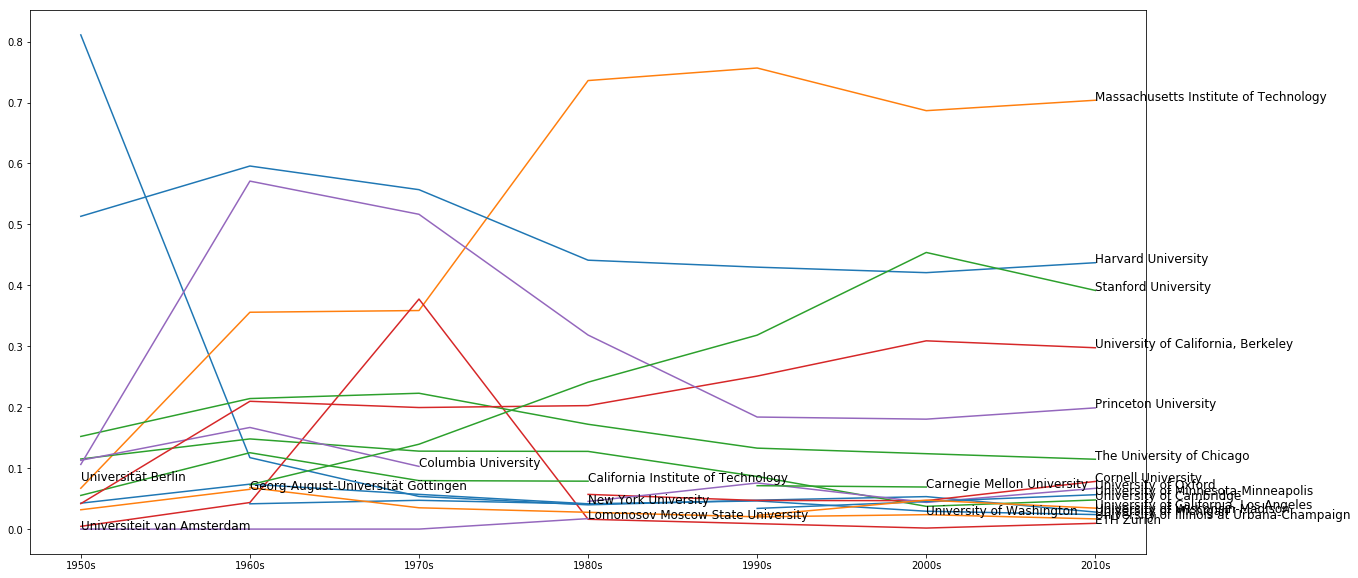

In [12]:
fig, ax = plt.subplots(figsize = (20, 10))
for i, school in enumerate(all_cent.school.unique()):
    school_cent = all_cent.query("school == '{}'".format(school))
    ax.plot(school_cent["decade"], school_cent["cent"], c = sns.color_palette()[i % 5])
    ax.annotate(school, [school_cent.iloc[-1]["decade"], school_cent.iloc[-1]["cent"]], fontsize = 12)

### Degree over time

In [13]:
all_deg = pd.concat(
    [pd.DataFrame([{"school": k, "deg": v, "decade": d["decade"]} for k, v in d["deg"].items()]) for d in decade_school_digraphs])

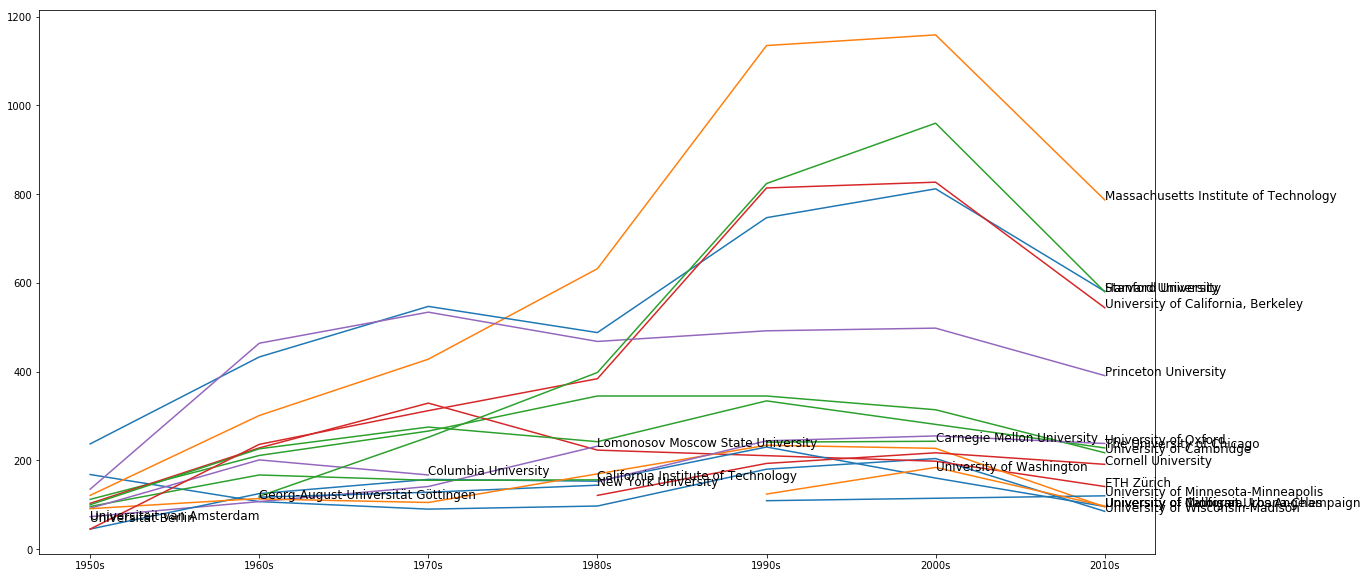

In [14]:
fig, ax = plt.subplots(figsize = (20, 10))
for i, school in enumerate(all_cent.school.unique()):
    school_deg = all_deg.query("school == '{}'".format(school))
    ax.plot(school_deg["decade"], school_deg["deg"], c = sns.color_palette()[i % 5])
    ax.annotate(school, [school_deg.iloc[-1]["decade"], school_deg.iloc[-1]["deg"]], fontsize = 12)

# Community detection

In [8]:
decade_school_graphs = [{
    "decade": dec,
    "school_g": s.make_school_graph(students.query("student_year_dec == '{}'".format(dec)))} for dec in decades]

/home/gautam_sisodia/math_geneology/code/schools.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  student_df["advisor_school"] + '|' + student_df["student_school"])


In [9]:
[nx.number_connected_components(d["school_g"]) for d in decade_school_graphs]

[17, 23, 13, 21, 24, 19, 17]

In [10]:
from networkx.algorithms import community

In [23]:
for d in decade_school_graphs:
    d["school_sg"] = top_degree_subgraph(decade_school_graphs[-1]["school_g"], "weight", 25)
    d["comm"] = list(community.label_propagation.asyn_lpa_communities(d["school_sg"], weight = "weight"))

In [24]:
layout = nx.spring_layout(decade_school_graphs[-1]["school_sg"], weight = "weight")

In [25]:
def draw_graph_layout_comm(graph, layout, ax, comm = None):
    """
    draw the graph with the given layout on the given axis
    """
    c = [[i for i, c in enumerate(comm) if k in c][0] for k, v in layout.items()]
    print(c)
    c_norm = [1.0 * i / max(c) for i in c]
    print(c)
    ax.scatter([v[0] for k, v in layout.items()], [v[1] for k, v in layout.items()], c = c_norm, cmap = "Dark2", s = 150)
    for k, v in layout.items():
        ax.annotate(k, v, xytext = (5, 5), textcoords = "offset points", fontsize = 14)
    for e in [e for e in graph.edges]:
        ax.plot([layout[i][0] for i in e], [layout[i][1] for i in e], c = "steelblue", lw = 0.1)
    ax.axis("off")

In [26]:
decade_school_graphs[-1]["comm"]

[{'California Institute of Technology',
  'Carnegie Mellon University',
  'Columbia University',
  'Cornell University',
  'Harvard University',
  'Massachusetts Institute of Technology',
  'New York University',
  'Princeton University',
  'Purdue University',
  'Stanford University',
  'The University of Chicago',
  'University of California, Berkeley',
  'University of California, Los Angeles',
  'University of Illinois at Urbana-Champaign',
  'University of Michigan',
  'University of Minnesota-Minneapolis',
  'University of Washington',
  'University of Wisconsin-Madison'},
 {'Université Paris-Sud XI - Orsay',
  'Université Pierre-et-Marie-Curie - Paris VI'},
 {'Technische Universität Berlin'},
 {'Rheinische Friedrich-Wilhelms-Universität Bonn'},
 {'University of Cambridge', 'University of Oxford'},
 {'ETH Zürich'}]

[0, 1, 0, 0, 0, 2, 0, 3, 0, 4, 0, 1, 0, 0, 0, 0, 0, 4, 0, 5, 0, 0, 0, 0, 0]
[0, 1, 0, 0, 0, 2, 0, 3, 0, 4, 0, 1, 0, 0, 0, 0, 0, 4, 0, 5, 0, 0, 0, 0, 0]


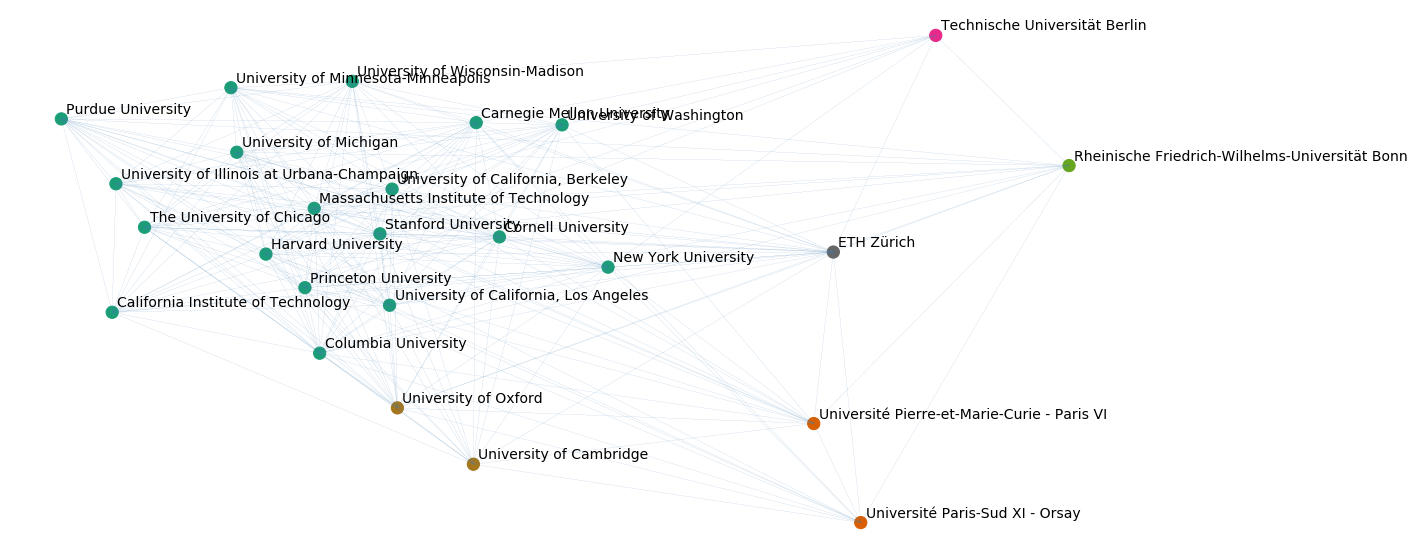

In [27]:
fig, ax = plt.subplots(figsize = (20, 10))
draw_graph_layout_comm(graph = decade_school_graphs[-1]["school_sg"], layout = layout, ax = ax, comm = decade_school_graphs[-1]["comm"])
fig.savefig("./../presentation/school_communities.png", dpi = 100, bbox_inches = "tight")